# Triples (or higher order) systems in each samples

In [1]:
import sys
sys.path.append('../src')
import P_binary
import P_random
import P_posterior
import const as c
import time
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import corner
import pickle


%matplotlib inline

### First, NLTT matches

In [2]:
# Full NLTT Catalog
filename = ('../data/rNLTT/catalog_tabs.dat')
t_full = Table.read(filename, format='ascii', guess=True)

# Change proper motion units from asec/yr to mas/yr
t_full['mu_ra'] = 1.0e3*t_full['mu_ra']
t_full['mu_dec'] = 1.0e3*t_full['mu_dec']
t_full['mu_ra_err'] = 1.0e3*t_full['mu_ra_err']
t_full['mu_dec_err'] = 1.0e3*t_full['mu_dec_err']

# Select only stars with proper motion uncertainties greater than 0.1 mas/yr - remove junk
ids_good = np.intersect1d(np.where(t_full['mu_ra_err'] >= 0.1), np.where(t_full['mu_dec_err'] >= 0.1))
t = t_full[ids_good]
print t.dtype

[('NLTT', '<i8'), ('ra', '<f8'), ('dec', '<f8'), ('mu_ra', '<f8'), ('mu_dec', '<f8'), ('mu_ra_err', '<f8'), ('mu_dec_err', '<f8'), ('HIP', '<i8'), ('V', '<f8'), ('B', '<f8'), ('R', '<f8'), ('J', '<f8'), ('H', '<f8'), ('K', '<f8')]


In [3]:
# Now read in matched pairs
NLTT_prob = pickle.load( open("../data/rNLTT/prob_out.data", "rb"))
print NLTT_prob.dtype

[('i_1', '<i4'), ('i_2', '<i4'), ('ID_1', '<i4'), ('ID_2', '<i4'), ('P_random', '<f8'), ('P_binary', '<f8'), ('P_posterior', '<f8')]


### TGAS matches

In [4]:
# Read in sample from TGAS table
dtype = [('ID','<i8'),('tyc','S11'),('hip','<i8'),('ra','<f8'),('dec','<f8'),('mu_ra','<f8'),('mu_dec','<f8'), \
     ('mu_ra_err','<f8'),('mu_dec_err','<f8'),('plx','<f8'),('plx_err','<f8')]

tgas_full = np.array([], dtype=dtype)

for i in np.arange(1):
    if i < 10:
        filename = ('../data/TGAS/TgasSource_000-000-00' + str(i) + '.csv')
    else:
        filename = ('../data/TGAS/TgasSource_000-000-0' + str(i) + '.csv')

    print filename
    tgas_tmp = Table.read(filename, format='csv', guess=True)
    
    

    tgas = np.zeros(len(tgas_tmp), dtype=dtype)

    tgas['ID'] = tgas_tmp['source_id']
    tgas['tyc'] = tgas_tmp['tycho2_id']
    tgas['hip'] = tgas_tmp['hip']
    tgas['ra'] = tgas_tmp['ra']
    tgas['dec'] = tgas_tmp['dec']
    tgas['mu_ra'] = tgas_tmp['pmra']
    tgas['mu_ra_err'] = tgas_tmp['pmra_error']
    tgas['mu_dec'] = tgas_tmp['pmdec']
    tgas['mu_dec_err'] = tgas_tmp['pmdec_error']
    tgas['plx'] = tgas_tmp['parallax']
    tgas['plx_err'] = tgas_tmp['parallax_error']

    tgas_full = np.append(tgas_full, tgas)



../data/TGAS/TgasSource_000-000-000.csv


In [5]:
idx_max = len(tgas_full)
print idx_max

134865


In [6]:
TGAS_prob = pickle.load( open("../data/TGAS/TGAS_match_1.p", "rb"))
print TGAS_prob.dtype
print len(TGAS_prob)

[('i_1', '<i4'), ('i_2', '<i4'), ('ID_1', '<i4'), ('ID_2', '<i4'), ('P_random', '<f8'), ('P_binary', '<f8'), ('P_posterior', '<f8'), ('theta', '<f8'), ('mu_ra_1', '<f8'), ('mu_dec_1', '<f8'), ('mu_ra_2', '<f8'), ('mu_dec_2', '<f8'), ('plx_1', '<f8'), ('plx_2', '<f8')]
2570


In [7]:
print TGAS_prob[0:2]

[ (35, 36, 240384, 239616, 1.039850445142101e-14, 0.001913309014934047, 0.9999999910093657, 0.027578937746490933, -45.76365680943734, -46.76110081818987, -46.19526134370247, -47.02319502745229, 7.446147291703792, 7.380755126195536)
 (59, 60, 116096, 115712, 5.295377167363056e-09, 4.748592669467103e-18, 1.3665046983647355e-15, 0.07598713277074795, 10.81026248051149, 0.8928437516319168, 13.442826338873022, -3.4436208395439167, 3.2168613633458185, 1.7809301030231435)]


In [11]:
def find_multiples(catalog):
    
    triple_pairs, quad_pairs, quint_pairs = match_multiple_IDs(catalog)
    
    triple_angles = get_triple_angles(triple_pairs)
    
    return triple_pairs, triple_angles, quad_pairs, quint_pairs
    
    
    
def match_multiple_IDs(catalog):

    dtype_3 = ([('i_1', 'i8'), ('i_2', 'i8'), ('i_3', 'i8')])
    dtype_4 = ([('i_1', 'i8'), ('i_2', 'i8'), ('i_3', 'i8'), ('i_4', 'i8')])
    dtype_5 = ([('i_1', 'i8'), ('i_2', 'i8'), ('i_3', 'i8'), ('i_4', 'i8'), ('i_5', 'i8')])
    triple_pairs = np.array([], dtype=dtype_3)
    quad_pairs = np.array([], dtype=dtype_4)
    quint_pairs = np.array([], dtype=dtype_5)
    
    N_triple = 0
    for i in np.arange(len(catalog)-1):
        
        
        # Make sure we don't go beyond the bounds of the subset of the TGAS catalog we are testing
        if catalog['i_1'][i] > idx_max or catalog['i_2'][i] > idx_max: continue
            
        # Only select pairs with a posterior probability above 50%
        if catalog['P_posterior'][i] < 0.5: continue
            
        # Check to make sure entry has not already been identified as part of a multiple system
        matched = False
        for pair in triple_pairs:
            if np.any(pair['i_1'] == catalog['i_1'][i]) or \
               np.any(pair['i_2'] == catalog['i_1'][i]) or \
               np.any(pair['i_3'] == catalog['i_1'][i]):
                matched = True
        for pair in quad_pairs: 
            if np.any(pair['i_1'] == catalog['i_1'][i]) or \
               np.any(pair['i_2'] == catalog['i_1'][i]) or \
               np.any(pair['i_3'] == catalog['i_1'][i]) or \
               np.any(pair['i_4'] == catalog['i_1'][i]):
                matched = True
        for pair in quint_pairs: 
            if np.any(pair['i_1'] == catalog['i_1'][i]) or \
               np.any(pair['i_2'] == catalog['i_1'][i]) or \
               np.any(pair['i_3'] == catalog['i_1'][i]) or \
               np.any(pair['i_4'] == catalog['i_1'][i]) or \
               np.any(pair['i_5'] == catalog['i_1'][i]):
                matched = True
        if matched: continue
            
            
        
        # Look for matching indices
        i2 = np.arange(len(catalog) - i - 1) + i + 1
        idx = np.array([], dtype='i8')
        for j in i2:
            
            
            # Make sure we don't go beyond the bounds of the subset of the TGAS catalog we are testing
            if catalog['i_1'][j] > idx_max or catalog['i_2'][j] > idx_max: continue

            # Only select pairs with a posterior probability above 50%
            if catalog['P_posterior'][j] < 0.5: continue

            if catalog['i_1'][j] == catalog['i_1'][i] \
               or catalog['i_1'][j] == catalog['i_2'][i] \
               or catalog['i_2'][j] == catalog['i_1'][i] \
               or catalog['i_2'][j] == catalog['i_2'][i]:
                    
                        
                # Default is to add the entry
                match_1 = True
                match_2 = True

            
                if not np.any(idx == catalog['i_1'][i]): idx = np.append(idx, catalog['i_1'][i])
                if not np.any(idx == catalog['i_2'][i]): idx = np.append(idx, catalog['i_2'][i])
                if not np.any(idx == catalog['i_1'][j]): idx = np.append(idx, catalog['i_1'][j])
                if not np.any(idx == catalog['i_2'][j]): idx = np.append(idx, catalog['i_2'][j])
                
                
        if len(idx) == 3:
            triple_pairs = np.append(triple_pairs, np.array([(idx[0], idx[1], idx[2])], dtype=dtype_3))
                
        if len(idx) == 4:
            quad_pairs = np.append(quad_pairs, np.array([(idx[0], idx[1], idx[2], idx[3])], dtype=dtype_4))

        if len(idx) == 5:
            quint_pairs = np.append(quint_pairs, np.array([(idx[0], idx[1], idx[2], idx[3], idx[4])], dtype=dtype_5))

            

                
#                 if triple_pairs.size != 0:
                    
#                     # Add entry for first match
#                     for k in np.arange(len(triple_pairs)):
#                         ra1_a = t['ra'][np.where(t['NLTT'] == triple_pairs['ID_1'][k])][0]
#                         ra2_a = t['ra'][np.where(t['NLTT'] == triple_pairs['ID_2'][k])][0]
#                         ra1_b = t['ra'][np.where(t['NLTT'] == catalog['ID_1'][i])][0]
#                         ra2_b = t['ra'][np.where(t['NLTT'] == catalog['ID_2'][i])][0]
#                         if ra1_a == ra1_b and ra2_a == ra2_b: match_1 = False



#                     # Add entry for second match
#                     for k in np.arange(len(triple_pairs)):
#                         ra1_a = t['ra'][np.where(t['NLTT'] == triple_pairs['ID_1'][k])][0]
#                         ra2_a = t['ra'][np.where(t['NLTT'] == triple_pairs['ID_2'][k])][0]
#                         ra1_b = t['ra'][np.where(t['NLTT'] == catalog['ID_1'][j])][0]
#                         ra2_b = t['ra'][np.where(t['NLTT'] == catalog['ID_2'][j])][0]
#                         if ra1_a == ra1_b and ra2_a == ra2_b: match_2 = False



#                 # Add entry for first match
#                 if match_1 == True:
#                     id1 = np.where(t['NLTT'] == catalog['ID_1'][i])[0]
#                     id2 = np.where(t['NLTT'] == catalog['ID_2'][i])[0]
#                     theta = P_random.get_theta_proj_degree(t['ra'][id1], t['dec'][id1], t['ra'][id2], t['dec'][id2])[0]
#                     print id1, id2, catalog['ID_1'][i], catalog['ID_1'][j], theta
#                     match = np.zeros(1, dtype=dtype)
#                     match[0] = catalog['ID_1'][i], catalog['ID_2'][i], theta
#                     triple_pairs = np.append(triple_pairs, match)
                    
#                 # Add entry for second match
#                 if match_2 == True:
#                     id1 = np.where(t['NLTT'] == catalog['ID_1'][j])[0][0]
#                     id2 = np.where(t['NLTT'] == catalog['ID_2'][j])[0][0]
#                     theta = P_random.get_theta_proj_degree(t['ra'][id1], t['dec'][id1], t['ra'][id2], t['dec'][id2])
#                     match = np.zeros(1, dtype=dtype)
#                     match[0] = catalog['ID_1'][j], catalog['ID_2'][j], theta
#                     triple_pairs = np.append(triple_pairs, match)




    return triple_pairs, quad_pairs, quint_pairs



def get_triple_angles(triple_pairs):
    
    dtype_angle_3 = ([('theta_1', 'f8'), ('theta_2', 'f8'), ('theta_3', 'f8')])
    triple_angles = np.array([], dtype=dtype_angle_3)
    
    for idx in triple_pairs:
        
        angle1 = 3600.0 * P_random.get_theta_proj_degree(tgas_full[idx[0]]['ra'], tgas_full[idx[0]]['dec'], 
                                                         tgas_full[idx[1]]['ra'], tgas_full[idx[1]]['dec'])
        angle2 = 3600.0 * P_random.get_theta_proj_degree(tgas_full[idx[0]]['ra'], tgas_full[idx[0]]['dec'], 
                                                         tgas_full[idx[2]]['ra'], tgas_full[idx[2]]['dec'])
        angle3 = 3600.0 * P_random.get_theta_proj_degree(tgas_full[idx[1]]['ra'], tgas_full[idx[1]]['dec'], 
                                                         tgas_full[idx[2]]['ra'], tgas_full[idx[2]]['dec'])
        
        triple_angles = np.append(triple_angles, np.array([(angle1, angle2, angle3)], dtype=dtype_angle_3))
        
        
    return triple_angles

In [12]:
triple_pairs, triple_angles, quad_pairs, quint_pairs = find_multiples(TGAS_prob)

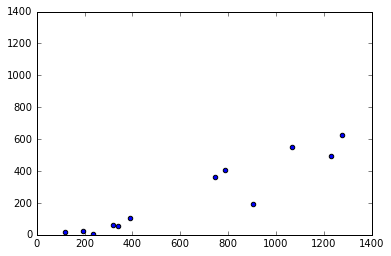

In [10]:
angle_min = np.zeros(len(triple_angles))
angle_max = np.zeros(len(triple_angles))

for i, angle in zip(np.arange(len(triple_angles)), triple_angles):
    angle_min[i] = np.min([angle['theta_1'], angle['theta_2'], angle['theta_3']])
    angle_max[i] = np.max([angle['theta_1'], angle['theta_2'], angle['theta_3']])

    
plt.scatter(angle_max, angle_min)

plt.xlim(0.0, 1400)
plt.ylim(0.0, 1400)

plt.show()

In [14]:
print triple_pairs
print
print quad_pairs
print
print quint_pairs

[(4864, 4865, 4866) (8411, 8448, 8449) (8446, 8447, 8452)
 (8856, 8862, 9547) (9207, 9208, 9240) (9222, 9534, 9535)
 (9543, 9551, 9553) (9555, 9557, 9560) (22671, 22673, 22674)
 (32194, 32196, 32195) (38729, 38782, 38783) (49884, 49885, 49886)]

[(8388, 8389, 8390, 8391) (8402, 8403, 8406, 8409) (8450, 8838, 8839, 8841)
 (8454, 8841, 8838, 8839) (8789, 8790, 8843, 8844)]

[(8421, 8422, 8444, 8455, 8423)]
